# Research Programming Project
Katie Morrice

12/16/2015

# Satellite Model Data Comparison

I work with oceanographic model simulations, and many of my model-data comparisons consist of comparing time series at specific locations to assess model skill. I am interested in conducting model-data comparisons using various satellite data. In this case, I look at monthly sea surface temperatures from the MODIS satellite. 

Satellite data were downloaded from here:
http://coastwatch.pfel.noaa.gov/data.html#


In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pyproj
from skimage.filters import roberts, sobel, scharr, prewitt
import pandas as pd
%matplotlib inline

In [2]:
# set font size for plots
plt.rcParams.update({'font.size': 14})

# Functions Used to Process and Plot Satellite and Model Data

In [3]:
LL_WGS84 = pyproj.Proj(proj='latlong',datum='WGS84',errcheck=True)
SPCS_N_OR = pyproj.Proj(init = 'nad27:3601')

In [4]:
def convertCoords(x, y):
    '''Converts model coordinaates x, y from state plane coordinates to lon/lat.
    '''
    lon_mod, lat_mod = pyproj.transform(SPCS_N_OR, LL_WGS84, x, y)
    return lon_mod, lat_mod

In [5]:
def getMonthSatRegion(filen):
    '''Extracts a particular region of interest from the satellite data.
    Assumes a monthly dataset, with only one record.
    Longitude ranges from -155 to -105, and latitude ranges from 22 to 51 for whole data.
    '''

    fn = nc.Dataset(filen,'r')

    # Read in the variables of interest.
    lon = fn.variables['lon'][:]
    lat = fn.variables['lat'][:]
    MWsstd = fn.variables['MWsstd'][0]

    # Make correction to longitude
    lon = lon - 360.0
    
    # Only interested in part of data that matches with model data. Limits were found above
    idx_lon = np.array(np.where((lon > lonmin) & (lon < lonmax)))
    idx_lat = np.array(np.where((lat > latmin) & (lat < latmax)))
    
    lon_min = idx_lon.min()
    lon_max = idx_lon.max()
    lat_min = idx_lat.min()
    lat_max = idx_lat.max()

    lon_sat = lon[lon_min:lon_max]
    lat_sat = lat[lat_min:lat_max]
    sst_sat = MWsstd[0, lat_min:lat_max, lon_min:lon_max]
    fn.close()

    return lon_sat, lat_sat, sst_sat

In [6]:
def readSELFEslab(fn):
    '''Reads in variables of interest from model data. 
    Coordinates must be converted from state plane coordinates to latitude and longitude. 
    The triangulation is required because the model is an unstructured triangular grid.
    '''
    fn = nc.Dataset(fn,'r')
    x = fn.variables['x'][:]
    y = fn.variables['y'][:]
    conn = fn.variables['connectivity'][:]
    temp = fn.variables['water_temperature'][:]
    [lon_mod, lat_mod] = convertCoords(x, y)
    triang = tri.Triangulation(lon_mod, lat_mod, conn)
    fn.close()
    
    return lon_mod, lat_mod, temp, triang

In [7]:
def month_avg(data):
    '''Calculates monthly average for the model data.  
    '''
    data_m1 = np.ma.masked_array(data,np.isnan(data))
    data_mean = np.mean(data_m1, axis = 1)
    mask = np.ma.getmask(data_mean)
    data_mean[mask] = np.nan
    
    return data_mean

# This initial attempt generates a runtimeWarning (mean of empty slice). The above is round about, but avoids warning.    
#    data_mean = np.nanmean(data, axis = 1) # This attempt generates a runtimeWarning (mean of empty slice)
#    return data_mean

In [8]:
def interpolateSELFE(triang,data,lon_sat,lat_sat):
    '''Interpolates the SELFE data set to the same grid as the satellite. Interpolation method used is due to 
    the model being an unstructured triangular grid.
    '''
    interp = tri.LinearTriInterpolator(triang, data)
    xx,yy = np.meshgrid(lon_sat, lat_sat)
    mod_interp = interp(xx,yy)
    
    return mod_interp

In [9]:
def load_coast(file_name):
    '''Loads coastline data to ease interpretation of plots.
    '''
    data = np.loadtxt(file_name)
    coast_x = data[:,0]
    coast_y = data[:,1]
    return coast_x, coast_y

In [10]:
def plume_region(lon, lat, sat_data, mod_data):
    '''Extracts data for region that is closer to the plume.
    '''
    idx_lon = np.array(np.where((lon > -125.2) & (lon < -123.3)))
    idx_lat = np.array(np.where((lat > 45) & (lat < 47)))
    lon_min = idx_lon.min()
    lon_max = idx_lon.max()
    lat_min = idx_lat.min()
    lat_max = idx_lat.max()
    lon_plume = lon[lon_min:lon_max]
    lat_plume = lat[lat_min:lat_max]
    sat = sat_data[lat_min:lat_max, lon_min:lon_max]
    mod = mod_data[lat_min: lat_max, lon_min:lon_max]

    return lon_plume, lat_plume, sat, mod

In [11]:
def plume_edges(data,type):
    ''' Detects edges in the supplied data set. Type refers to the filter type used for canny edge. 
    '''    
    data1=data.copy()
    data1[np.where(data.mask == True)] = np.nan
    edge_data = type(data1)
    edge_data = np.ma.masked_invalid(edge_data)
    return edge_data

In [12]:
def plot_sat_mod(sat, mod, month, tmin, tmax):
    '''The satellite longitude and latitude are constant across the datasets, so there is no need to 
    supply the lon/lat for each month. tmin and tmax refer to the minimum and maximum used in the plot.
    '''
    # Mask part of satellite domain where there are not model data
    sat_m = np.ma.masked_where(np.ma.getmask(mod), sat)
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    p1 = plt.pcolor(lon_sat, lat_sat, sat_m, vmin = tmin, vmax = tmax, cmap = 'Spectral_r')
    plt.colorbar(p1,label='Temperature $^o$C')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Satellite, ' + month + ' 2005')

    plt.subplot(1,2,2)
    p2 = plt.pcolor(lon_sat, lat_sat, mod, vmin = tmin, vmax = tmax, cmap = 'Spectral_r')
    plt.colorbar(p2, label= 'Temperature $^o$C')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('SELFE Model, ' + month + ' 2005')
    plt.tight_layout()    

In [13]:
def plot_sat_mod_plume(sat, mod, month, tmin, tmax):
    '''Plots the plume region off of the Columbia river for satellite and model data. ''' 
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    p1 = plt.pcolor(lon_plume, lat_plume, sat, vmin = tmin, vmax = tmax, cmap = 'Spectral_r')
    plt.colorbar(p1,label='Temperature $^o$C')
    plt.plot(coast_x,coast_y,'black')
    plt.xlim(min(lon_plume),max(lon_plume))
    plt.ylim(min(lat_plume),max(lat_plume))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Plume, Satellite, ' + month + ' 2005')

    plt.subplot(1,2,2)
    p2 = plt.pcolor(lon_plume, lat_plume, mod, vmin = tmin, vmax = tmax, cmap = 'Spectral_r')
    plt.colorbar(p2, label= 'Temperature $^o$C')
    plt.plot(coast_x,coast_y,'black')
    plt.xlim(min(lon_plume),max(lon_plume))
    plt.ylim(min(lat_plume),max(lat_plume))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Plume, SELFE Model, ' + month + ' 2005')
    plt.tight_layout()

In [14]:
def plot_edges(sat, mod, month):
    '''Plots the output from the edge detection.'''
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.pcolor(lon_p,lat_p,sat)
    plt.plot(coast_x,coast_y,'black')
    plt.xlim(min(lon_plume),max(lon_plume))
    plt.ylim(min(lat_plume),max(lat_plume))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Satellite, ' + month + ' 2005')
    
    plt.subplot(1,2,2)
    plt.pcolor(lon_p,lat_p,mod)
    plt.plot(coast_x,coast_y,'black')
    plt.xlim(min(lon_plume),max(lon_plume))
    plt.ylim(min(lat_plume),max(lat_plume))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('SELFE Model, ' + month + ' 2005')
    plt.tight_layout()

# Data Files and Description of Data
There are satellite files that represent a monthly composite for each month. These data are somewhat similar to a monthly average, but do not represent a true monthly average. The composite images are created by averaging points over time. However, there could be some points for which only one data record exists for the entire month, due to high cloud cover. Thus, this is a best estimate at a monthly average, but may be inconsistent in the number of points used to get that average.

I also have model data extracted from the surface. The model data include surface values every 15 minutes for one month of data. Thus, these data require averaging. In addition, to do any model data comparisons, I must interpolate the model data to the satellite grid. However, given the limitations of the satellite data as noted above, doing a robust statistical analysis to compare these two data sets should be discouraged. Despite this limitation, these data sets can be compared at a basic level to find similar features, and basic statistical parameters between the two data sets may be compared.

In [15]:
ls SST_sat_data/ # satellite data

MW2005001_2005031_sstd.nc  MW2005182_2005212_sstd.nc
MW2005032_2005059_sstd.nc  MW2005213_2005243_sstd.nc
MW2005060_2005090_sstd.nc  MW2005244_2005273_sstd.nc
MW2005091_2005120_sstd.nc  MW2005274_2005304_sstd.nc
MW2005121_2005151_sstd.nc  MW2005305_2005334_sstd.nc
MW2005152_2005181_sstd.nc  MW2005335_2005365_sstd.nc


In [16]:
ls SELFE_slabs/ # model data

slab_temp_s-1_2005-02-01_2005-03-01.nc  slab_temp_s-1_2005-06-01_2005-07-01.nc
slab_temp_s-1_2005-03-01_2005-04-01.nc  slab_temp_s-1_2005-07-01_2005-08-01.nc
slab_temp_s-1_2005-04-01_2005-05-01.nc  slab_temp_s-1_2005-08-01_2005-09-01.nc
slab_temp_s-1_2005-05-01_2005-06-01.nc


In [17]:
# Read in coastline for model domain. This makes interpretation of plume figures easier. 
[coast_x, coast_y] = load_coast('coastline.dat')

# Data Extraction and Plotting of Figures
Here I am extracting variables from the satellite data and the model data. As mentioned previously, averaging and interpolating the model data must be done. 

Plotting the satellite and monthly-averaged model data provides a good indication of whether the model is simulating realistic values at the surface. Since it is a monthly average, it is not representative of features with short temporal scales.

In [18]:
# Model Data
[lon_mod,lat_mod,temp1,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-02-01_2005-03-01.nc')

# Minimum and maximum longitude and latitudes for model domain. Satellite data will be extracted for these ranges. 
lonmin = lon_mod.min()
lonmax = lon_mod.max()
latmin = lat_mod.min()
latmax = lat_mod.max()

# Satellite Data
[lon_sat, lat_sat, sst_Feb] = getMonthSatRegion('SST_sat_data/MW2005032_2005059_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_Feb = month_avg(temp1)
mod_Feb = interpolateSELFE(triang, temp_Feb, lon_sat, lat_sat)

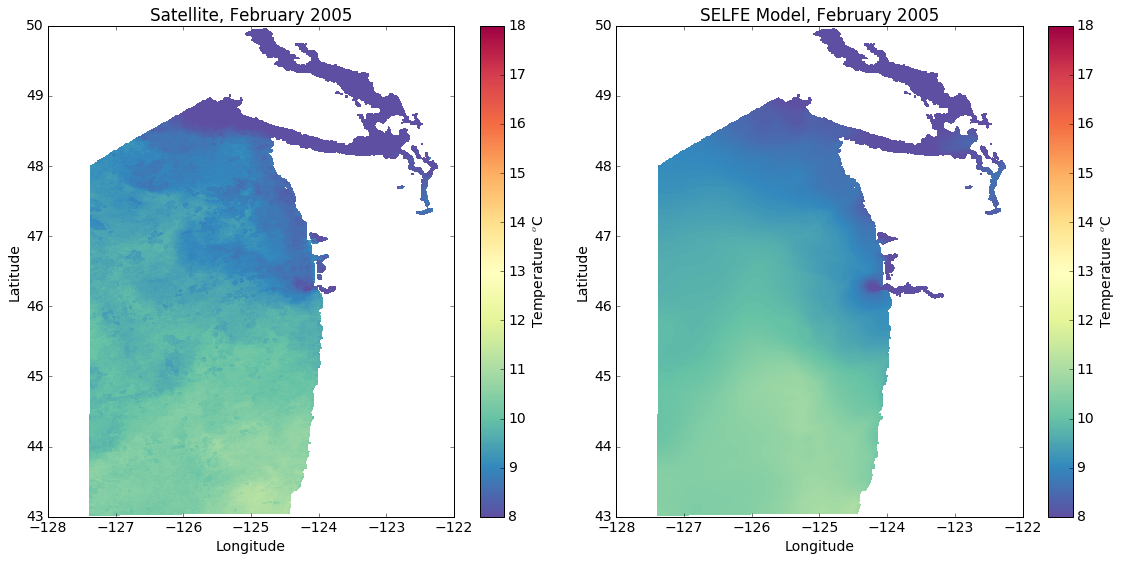

In [19]:
plot_sat_mod(sst_Feb, mod_Feb, 'February', 8, 18)

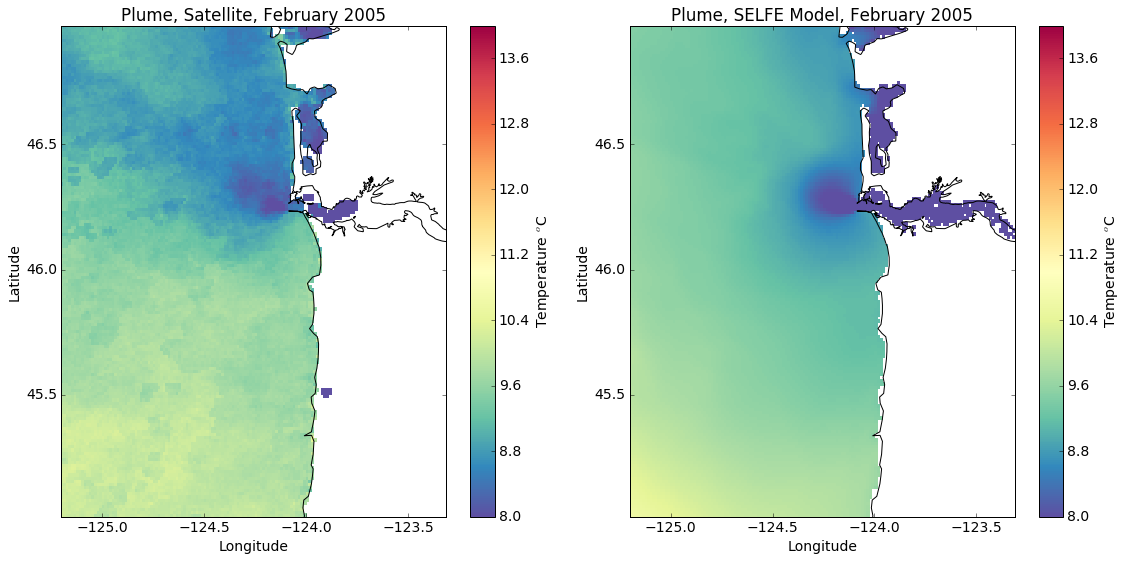

In [20]:
# Extract data for plume region
[lon_plume,lat_plume,sat_p_Feb, mod_p_Feb] = plume_region(lon_sat,lat_sat,sst_Feb, mod_Feb)
# Plot plume region
plot_sat_mod_plume(sat_p_Feb, mod_p_Feb, 'February', 8, 14)

# March 2005

In [21]:
# Model Data
[lon_mod,lat_mod,temp2,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-03-01_2005-04-01.nc')

# Satellite Data
[lon_sat, lat_sat, sst_Mar] = getMonthSatRegion('SST_sat_data/MW2005060_2005090_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_Mar = month_avg(temp2)
mod_Mar = interpolateSELFE(triang, temp_Mar, lon_sat, lat_sat)

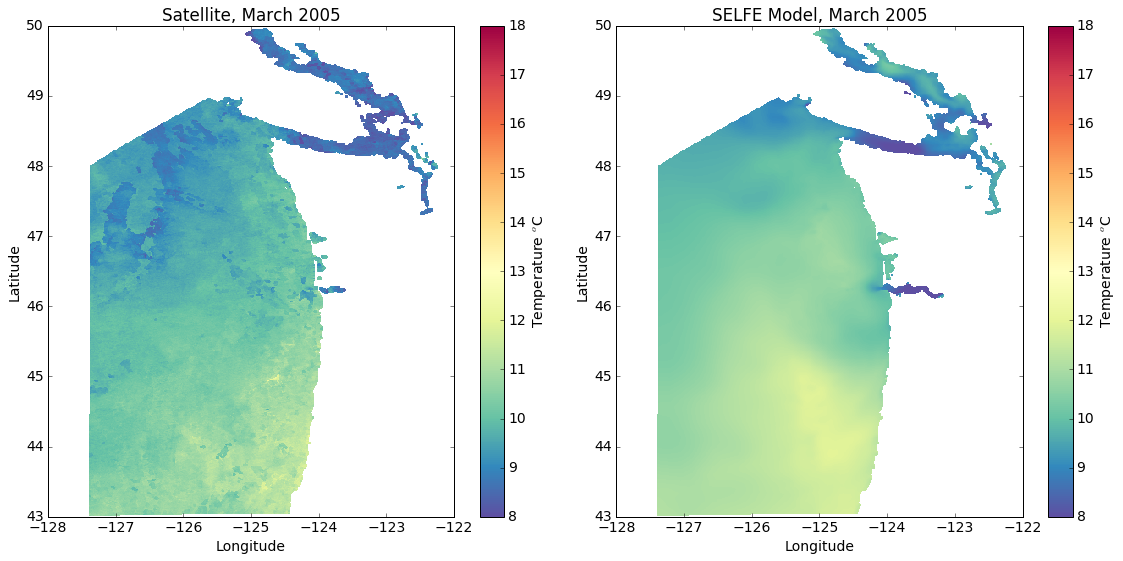

In [22]:
plot_sat_mod(sst_Mar, mod_Mar, 'March', 8, 18)

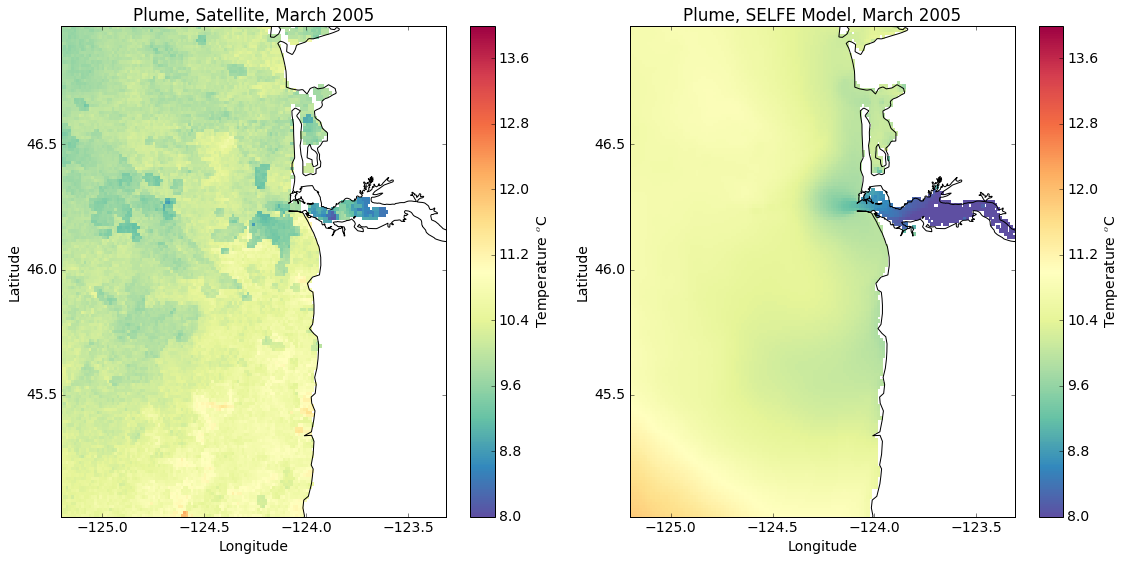

In [23]:
# Extract data for plume region
[lon_p,lat_p,sat_p_Mar, mod_p_Mar] = plume_region(lon_sat,lat_sat,sst_Mar, mod_Mar)
# Plot plume region
plot_sat_mod_plume(sat_p_Mar, mod_p_Mar, 'March', 8, 14)

# April 2005

In [24]:
# Model Data
[lon_mod,lat_mod,temp3,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-04-01_2005-05-01.nc')

# Satellite Data
[lon_sat, lat_sat, sst_Apr] = getMonthSatRegion('SST_sat_data/MW2005091_2005120_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_Apr = month_avg(temp3)
mod_Apr = interpolateSELFE(triang, temp_Apr, lon_sat, lat_sat)

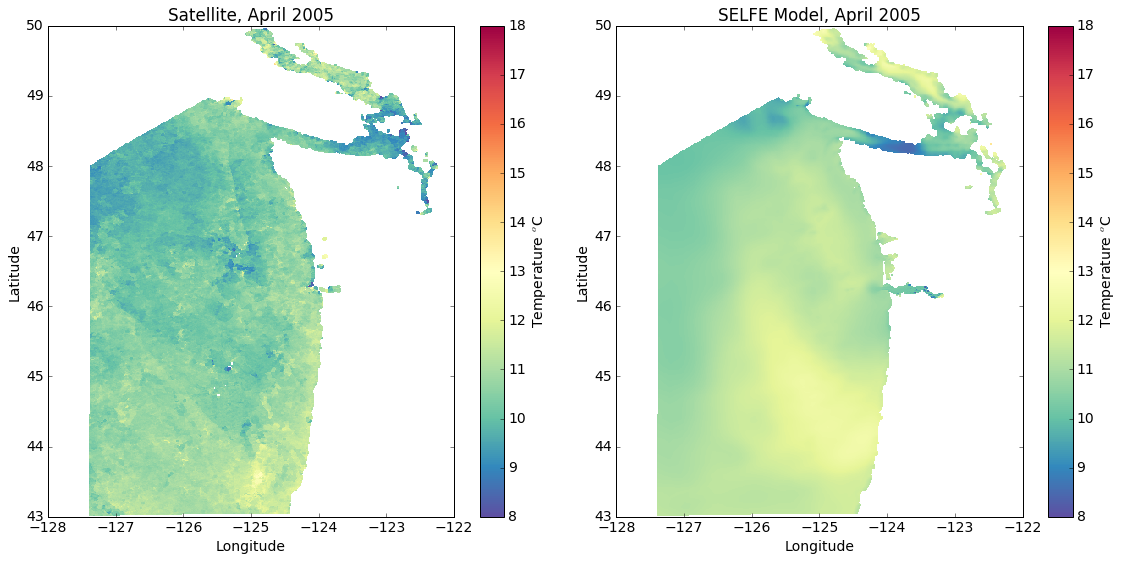

In [25]:
plot_sat_mod(sst_Apr, mod_Apr, 'April', 8, 18)

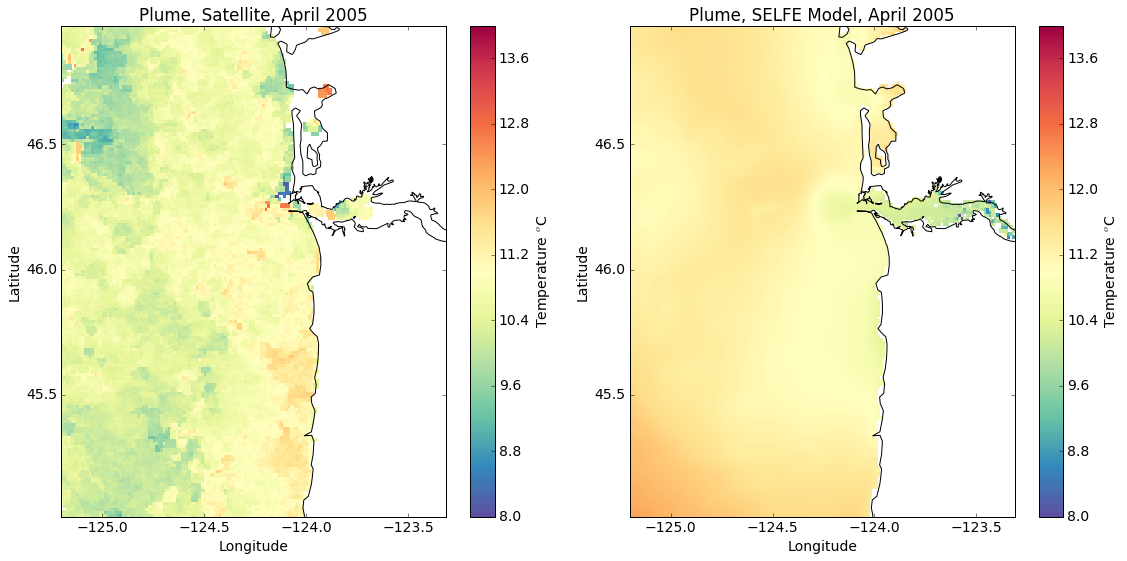

In [26]:
# Extract data for plume region
[lon_p,lat_p,sat_p_Apr, mod_p_Apr] = plume_region(lon_sat,lat_sat,sst_Apr, mod_Apr)
# Plot plume region
plot_sat_mod_plume(sat_p_Apr, mod_p_Apr, 'April', 8, 14)

# May 2005

In [27]:
# Model Data
[lon_mod,lat_mod,temp4,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-05-01_2005-06-01.nc')

# Satellite Data
[lon_sat, lat_sat, sst_May] = getMonthSatRegion('SST_sat_data/MW2005121_2005151_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_May = month_avg(temp4)
mod_May = interpolateSELFE(triang, temp_May, lon_sat, lat_sat)

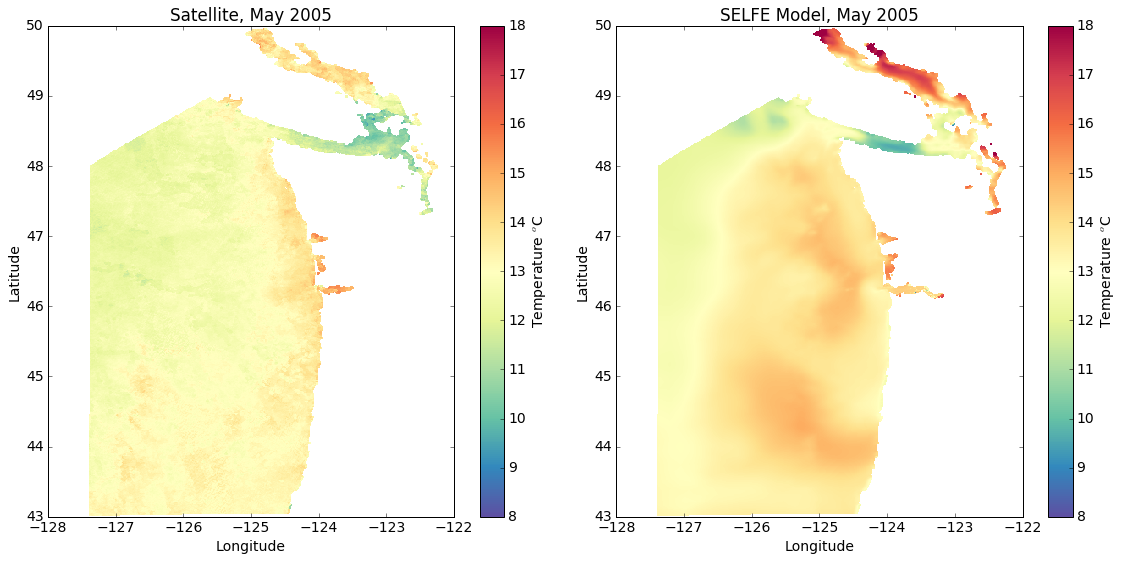

In [28]:
plot_sat_mod(sst_May, mod_May, 'May', 8, 18)

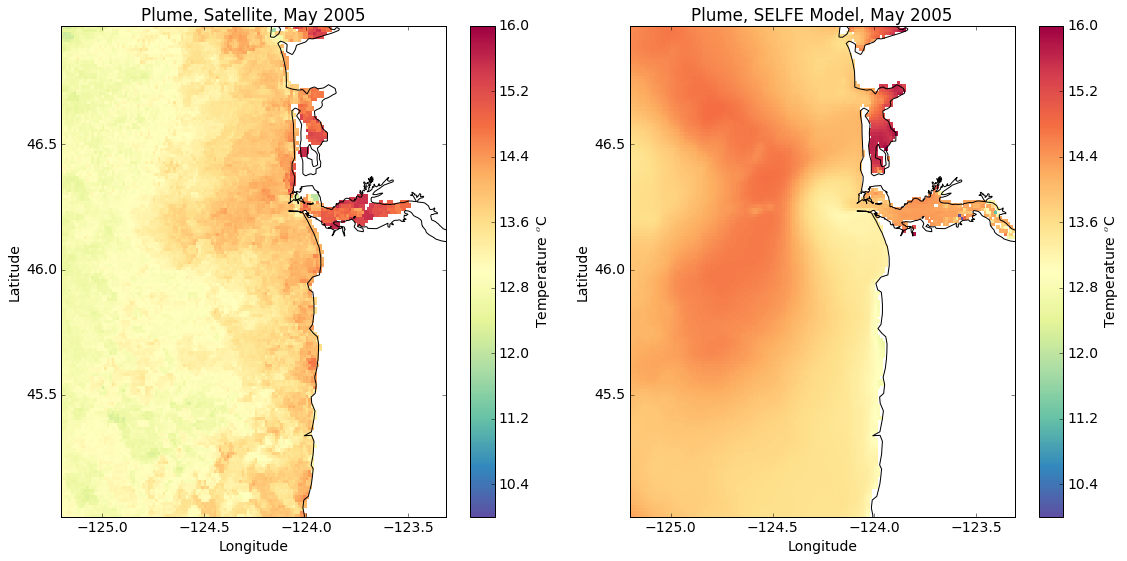

In [29]:
# Extract data for plume region
[lon_p,lat_p,sat_p_May, mod_p_May] = plume_region(lon_sat,lat_sat,sst_May, mod_May)
# Plot plume region
plot_sat_mod_plume(sat_p_May, mod_p_May, 'May', 10, 16)

# June 2005

In [30]:
# Model Data
[lon_mod,lat_mod,temp5,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-06-01_2005-07-01.nc')

# Satellite Data
[lon_sat, lat_sat, sst_June] = getMonthSatRegion('SST_sat_data/MW2005152_2005181_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_June = month_avg(temp5)
mod_June = interpolateSELFE(triang, temp_June, lon_sat, lat_sat)

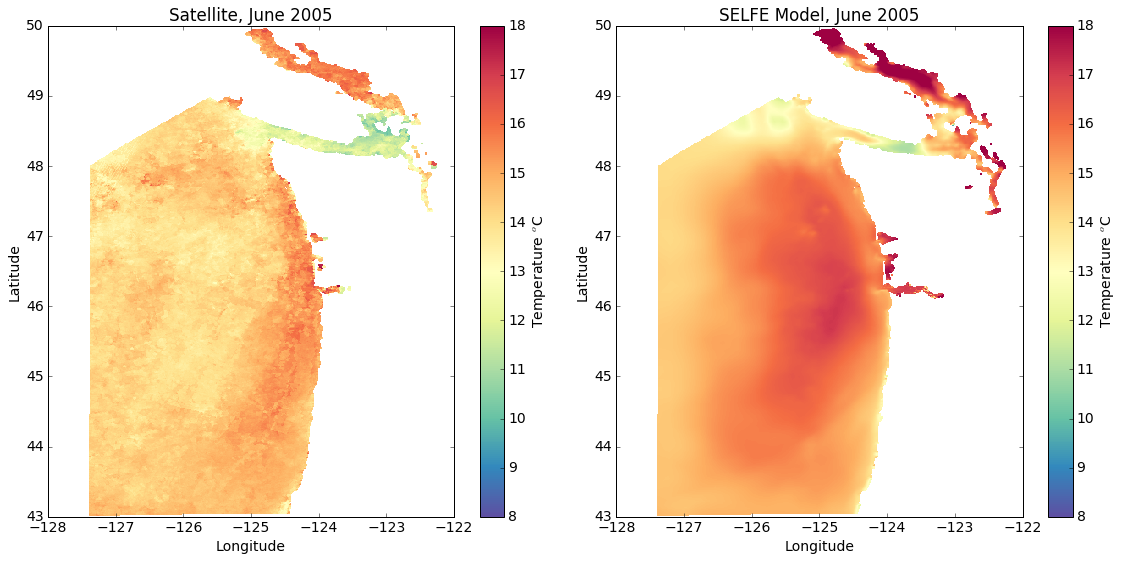

In [31]:
plot_sat_mod(sst_June, mod_June, 'June', 8, 18)

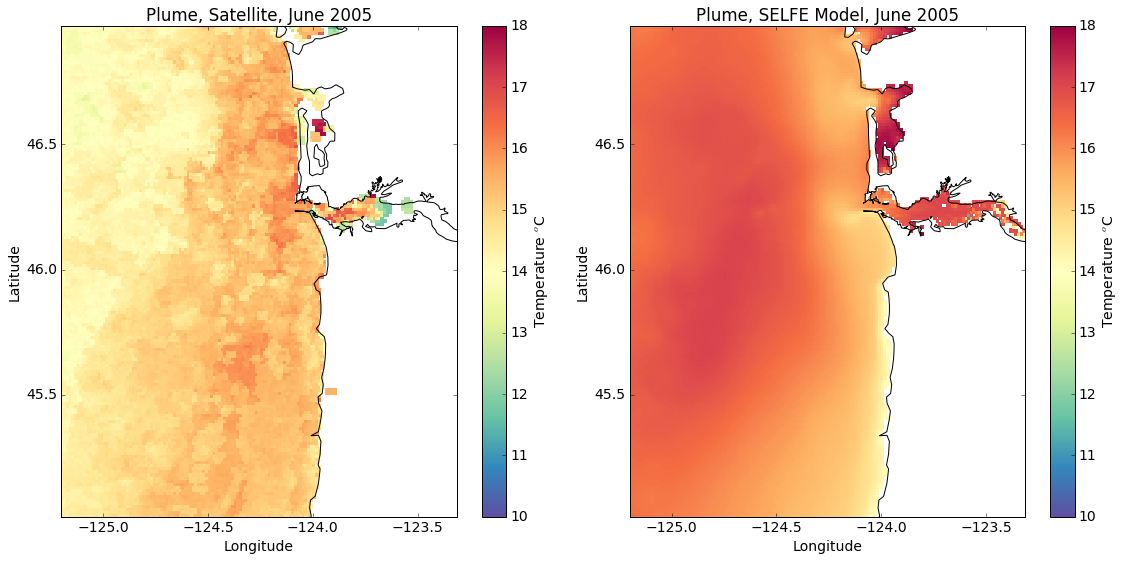

In [32]:
# Extract data for plume region
[lon_p,lat_p,sat_p_June, mod_p_June] = plume_region(lon_sat,lat_sat,sst_June, mod_June)
# Plot plume region
plot_sat_mod_plume(sat_p_June, mod_p_June, 'June', 10, 18)

# July 2005

In [33]:
# Model Data
[lon_mod,lat_mod,temp6,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-07-01_2005-08-01.nc')

# Satelite Data
[lon_sat, lat_sat, sst_July] = getMonthSatRegion('SST_sat_data/MW2005182_2005212_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_July = month_avg(temp6)
mod_July = interpolateSELFE(triang, temp_July, lon_sat, lat_sat)

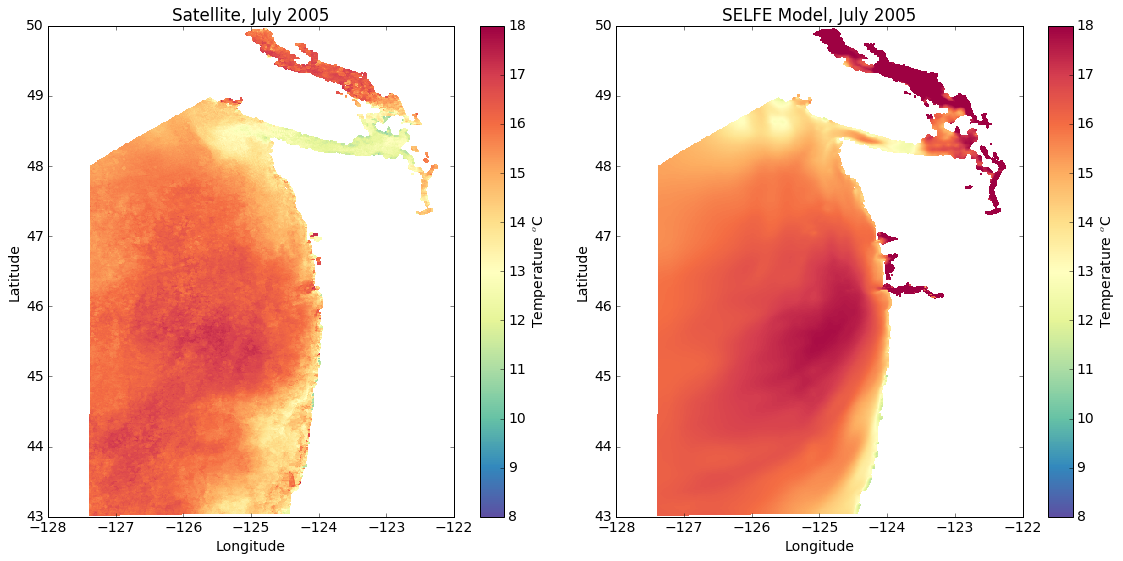

In [34]:
plot_sat_mod(sst_July, mod_July, 'July', 8, 18)

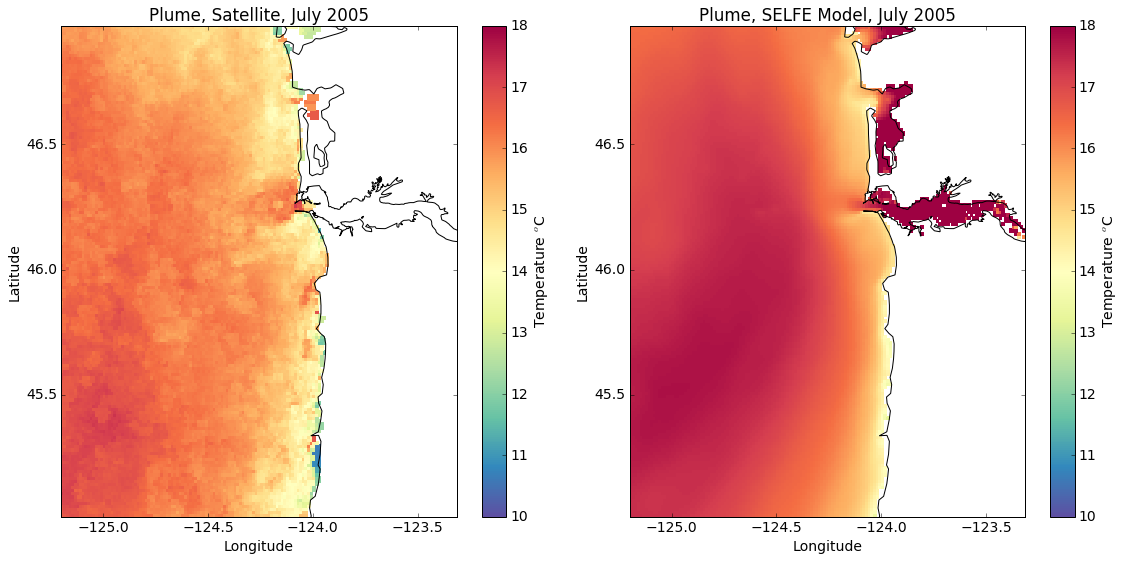

In [35]:
# Extract data for plume region
[lon_p,lat_p,sat_p_July, mod_p_July] = plume_region(lon_sat,lat_sat,sst_July, mod_July)
# Plot plume region
plot_sat_mod_plume(sat_p_July, mod_p_July, 'July', 10, 18)

# August 2005

In [36]:
# Model Data
[lon_mod,lat_mod,temp7,triang]=readSELFEslab('SELFE_slabs/slab_temp_s-1_2005-08-01_2005-09-01.nc')

# Satelite Data
[lon_sat, lat_sat, sst_Aug] = getMonthSatRegion('SST_sat_data/MW2005213_2005243_sstd.nc')

# Calculate monthly average for model data and interpolate to satellite grid
temp_Aug = month_avg(temp7)
mod_Aug = interpolateSELFE(triang, temp_Aug, lon_sat, lat_sat)

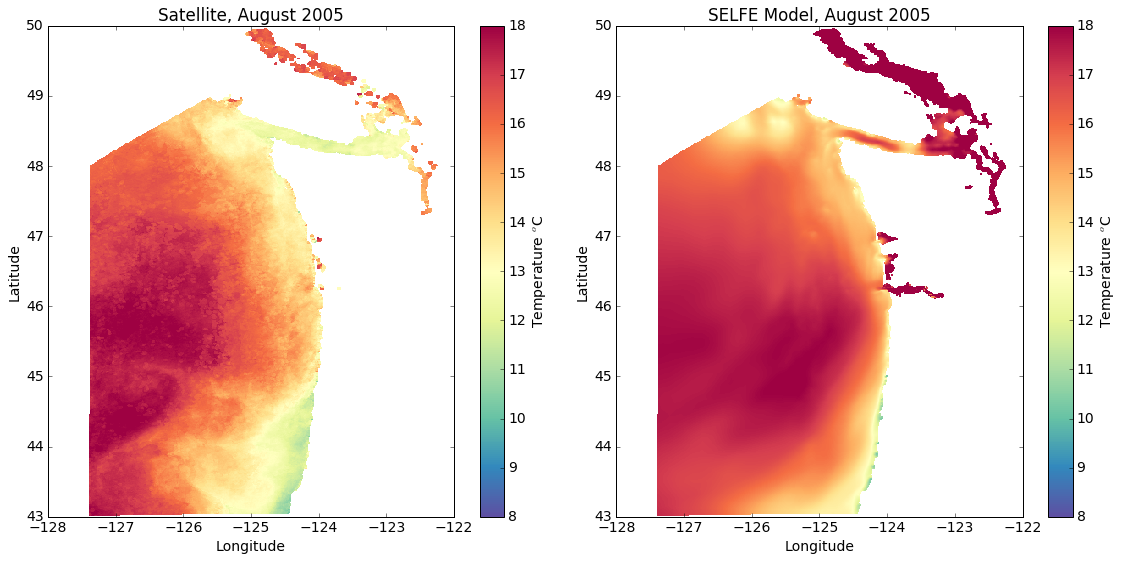

In [37]:
plot_sat_mod(sst_Aug, mod_Aug, 'August', 8, 18)

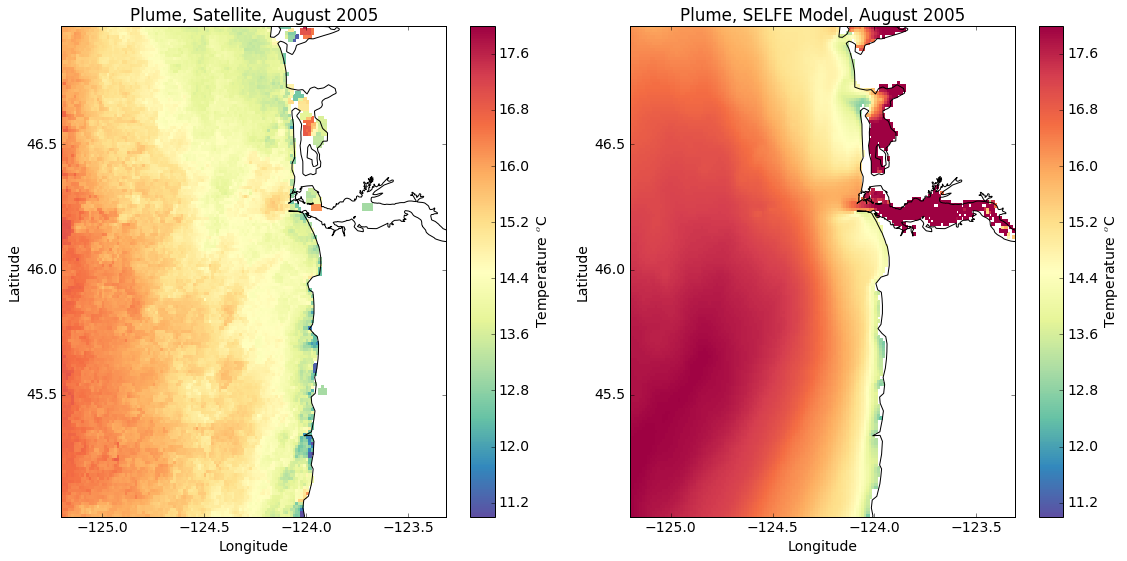

In [38]:
# Extract data for plume region
[lon_p,lat_p,sat_p_Aug, mod_p_Aug] = plume_region(lon_sat,lat_sat,sst_Aug, mod_Aug)
# Plot plume region
plot_sat_mod_plume(sat_p_Aug, mod_p_Aug, 'August', 11, 18)

# Compare the satellite and model data across months
Here I plot the satellite observations against the model data to see how well the model does compared to the satellite data. I have also plotted a 1:1 line. Ideally, data should follow this line if they match well with the satellite observations

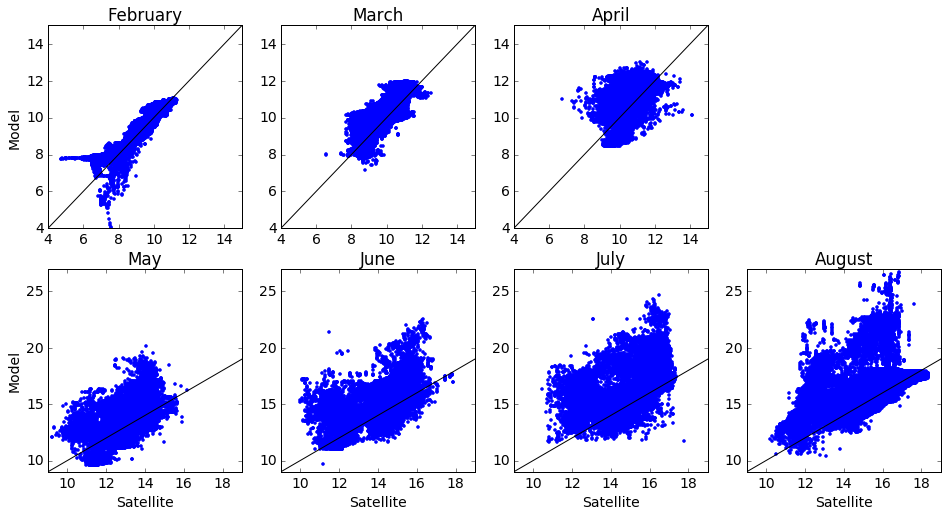

In [39]:
plt.figure(figsize = (16,8))
plt.subplot(2,4,1)
p1 = plt.plot(sst_Feb, mod_Feb,'.b')
plt.ylabel('Model')
plt.xlim(4,15)
plt.ylim(4,15)
plt.plot([4,15],[4,15],'-k')
plt.title('February')

plt.subplot(2,4,2)
p1 = plt.plot(sst_Mar, mod_Mar,'.b')
plt.xlim(4,15)
plt.ylim(4,15)
plt.plot([4,15],[4,15],'-k')
plt.title('March')

plt.subplot(2,4,3)
p1 = plt.plot(sst_Apr, mod_Apr,'.b')
plt.xlim(4,15)
plt.ylim(4,15)
plt.plot([4,15],[4,15],'-k')
plt.title('April')

plt.subplot(2,4,5)
p1 = plt.plot(sst_May, mod_May,'.b')
plt.ylabel('Model')
plt.xlabel('Satellite')
plt.xlim(9,19)
plt.ylim(9,27)
plt.plot([9,27],[9,27],'-k')
plt.title('May')

plt.subplot(2,4,6)
p1 = plt.plot(sst_June, mod_June,'.b')
plt.xlabel('Satellite')
plt.xlim(9,19)
plt.ylim(9,27)
plt.plot([9,27],[9,27],'-k')
plt.title('June')

plt.subplot(2,4,7)
p1 = plt.plot(sst_July, mod_July,'.b')
plt.xlabel('Satellite')
plt.xlim(9,19)
plt.ylim(9,27)
plt.plot([9,27],[9,27],'-k')
plt.title('July')


plt.subplot(2,4,8)
p1 = plt.plot(sst_Aug, mod_Aug,'.b')
plt.xlabel('Satellite')
plt.xlim(9,19)
plt.ylim(9,27)
plt.plot([9,27],[9,27],'-k')
plt.title('August')

# Edge Detection

From the figures above, the plume isn't always as obvious as I'd like. I had hoped to work with salinity data, but that data is not highly resolved enough. Thus, I must work with the available data set. The temperature is not ideal to detect the plume, but I will use it anyways, and try to identify a month from above where the plume is more evident. 

I'll start by looking at the month of February. This image isn't necessarily an improvement with regards to detecting the plume when compared to the plot above. However, it does indicate where there are sharp gradients that were perhaps obscured before. 

The satellite image looks very interesting. What I'm seeing is likely not true gradients but an artifact of how the monthly composites were created. For example, this image may contrast regions that have more points over a given month to create an average with regions that have fewer points. 

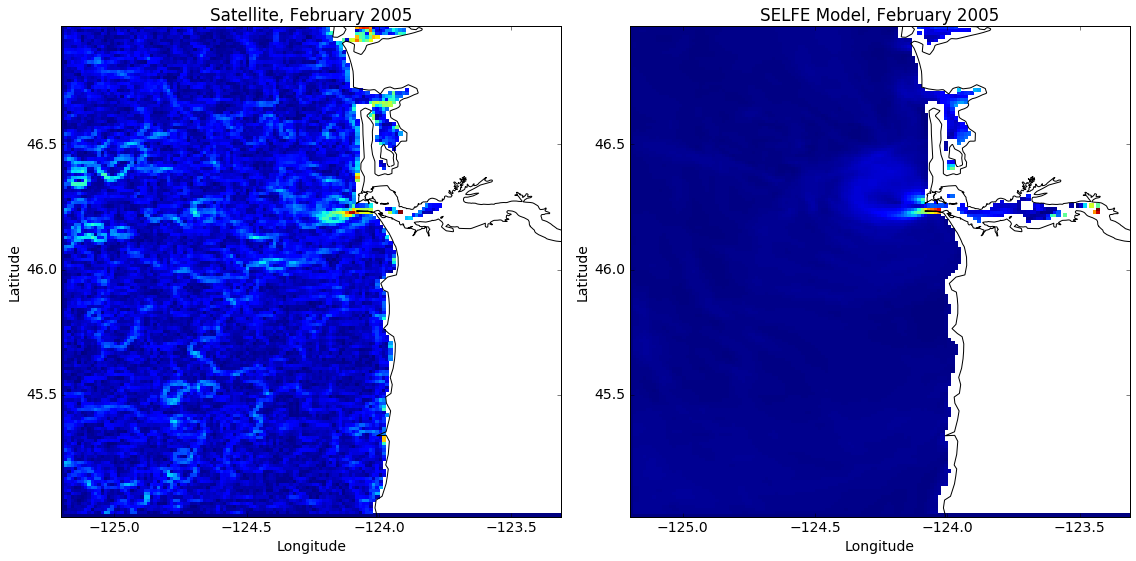

In [40]:
Feb_edge_sat = plume_edges(sat_p_Feb,sobel)
Feb_edge_mod = plume_edges(mod_p_Feb,sobel)

plot_edges(Feb_edge_sat, Feb_edge_mod, 'February')

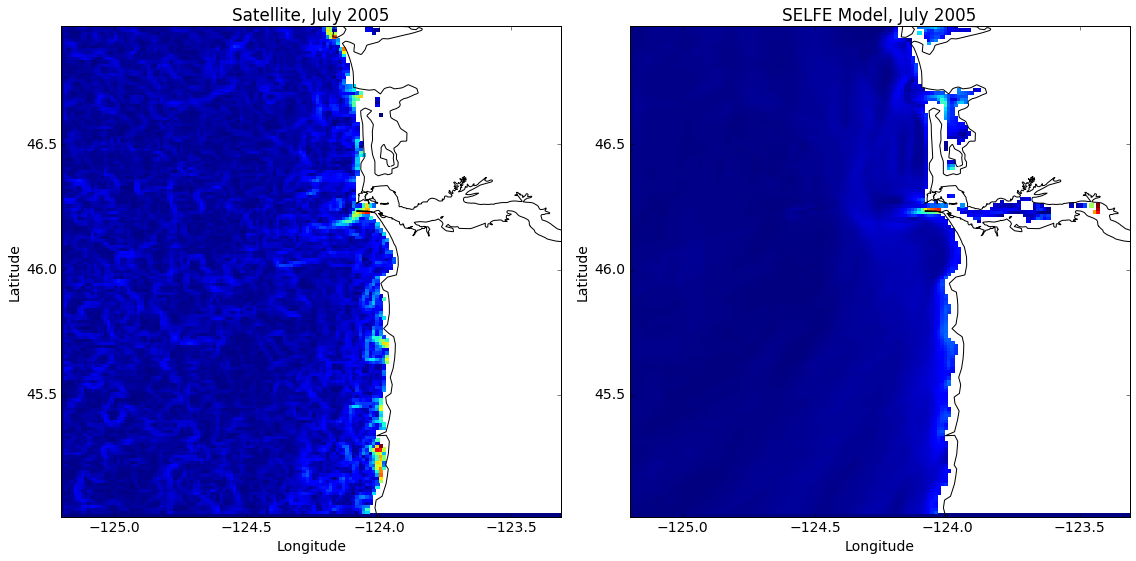

In [41]:
July_edge_sat = plume_edges(sat_p_July,sobel)
July_edge_mod = plume_edges(mod_p_July,sobel)

plot_edges(July_edge_sat, July_edge_mod, 'July')

# Additional Model Data Comparisons

Initially I wanted to do quite a bit to compare these two data sets so that I could assess model skill based on the satellite data. However, given the limitation of the satellite data in terms of how much data coverage there was for each month at a particular point, the best I can do is to generate some basic statistics for the satellite and model data. I also wanted to get some experience working with pandas, so the statistics for both the satellite and model data are reported in a data frame to ease interpretation.

I also conducted this same analysis on a different set of model results (not shown here). I saved the output from this run using `df.to_pickle('run19.pkl')`. These results are then loaded in this notebook so I can compare how my different model runs did with regards to mean temperatures.

In [42]:
sst_stats = np.zeros((7,2))
mod_stats = np.zeros((7,2))
sst_list=[sst_Feb,sst_Mar,sst_Apr,sst_May,sst_June,sst_July,sst_Aug] # satellite data to calculate means for
mod_list=[mod_Feb,mod_Mar,mod_Apr,mod_May,mod_June,mod_July,mod_Aug] # model data to calculate means for

In [43]:
def compute_stats(data):
    m = data.mean()
    v = data.var()
    return m, v

In [44]:
for i in range(0,7):
    [sst_stats[i,0],sst_stats[i,1]] = compute_stats(sst_list[i])
    [mod_stats[i,0],mod_stats[i,1]] = compute_stats(mod_list[i])

In [45]:
# Creation and concatenation of satellite and model statistics
df1 = pd.DataFrame(sst_stats, index=['February','March','April','May','June','July','August'])
df1.columns = ['Sat. mean','Sat. variance']
df2 = pd.DataFrame(mod_stats, index = ['February','March','April','May','June','July','August'])
df2.columns = ['Mod 1 mean','Mod 1 variance']
stats_df = pd.concat([df1, df2], axis = 1)
stats_df

,Sat. mean,Sat. variance,Mod 1 mean,Mod 1 variance
February,9.317760,0.979763,9.651097,0.768775
March,9.891230,0.501510,10.564634,0.586629
April,10.404433,0.343000,11.177222,0.372900
May,12.801801,0.408126,13.559450,0.776838
June,14.266463,0.589619,15.307573,1.010749
July,15.449819,1.320225,16.201028,1.373788
August,15.576982,2.847469,16.675948,2.447093


In [46]:
# Read in additional model run statistics
stats_run2 = pd.read_pickle('run19.pkl')
stats_run2.drop(stats_run2.columns[[0,1]], axis = 1, inplace = True)
stats_run2

,Mod 2 mean,Mod 2 variance
February,9.532471,0.578351
March,9.996297,0.401662
April,10.403374,0.172996
May,12.909019,0.402183
June,14.536340,0.763467
July,15.359735,1.421277
August,15.726454,2.972257


In [47]:
# Concatenate the two data frames
stats_df2 = pd.concat([stats_df, stats_run2], axis = 1)
stats_df2

,Sat. mean,Sat. variance,Mod 1 mean,Mod 1 variance,Mod 2 mean,Mod 2 variance
February,9.317760,0.979763,9.651097,0.768775,9.532471,0.578351
March,9.891230,0.501510,10.564634,0.586629,9.996297,0.401662
April,10.404433,0.343000,11.177222,0.372900,10.403374,0.172996
May,12.801801,0.408126,13.559450,0.776838,12.909019,0.402183
June,14.266463,0.589619,15.307573,1.010749,14.536340,0.763467
July,15.449819,1.320225,16.201028,1.373788,15.359735,1.421277
August,15.576982,2.847469,16.675948,2.447093,15.726454,2.972257


In [48]:
# Reorder columns
stats_df3 = stats_df2.reindex(columns=['Sat. mean','Mod 1 mean','Mod 2 mean','Sat. variance',
                                       'Mod 1 variance','Mod 2 variance'])
stats_df3

,Sat. mean,Mod 1 mean,Mod 2 mean,Sat. variance,Mod 1 variance,Mod 2 variance
February,9.317760,9.651097,9.532471,0.979763,0.768775,0.578351
March,9.891230,10.564634,9.996297,0.501510,0.586629,0.401662
April,10.404433,11.177222,10.403374,0.343000,0.372900,0.172996
May,12.801801,13.559450,12.909019,0.408126,0.776838,0.402183
June,14.266463,15.307573,14.536340,0.589619,1.010749,0.763467
July,15.449819,16.201028,15.359735,1.320225,1.373788,1.421277
August,15.576982,16.675948,15.726454,2.847469,2.447093,2.972257


In [49]:
dates = np.arange('2005-02', '2005-09', dtype = 'datetime64[M]')
sat = stats_df3['Sat. mean'].values
run16 = stats_df3['Mod 1 mean'].values
run19 = stats_df3['Mod 2 mean'].values

(array([ 731978.,  732006.,  732037.,  732067.,  732098.,  732128.,  732159.]),
 <a list of 7 Text xticklabel objects>)

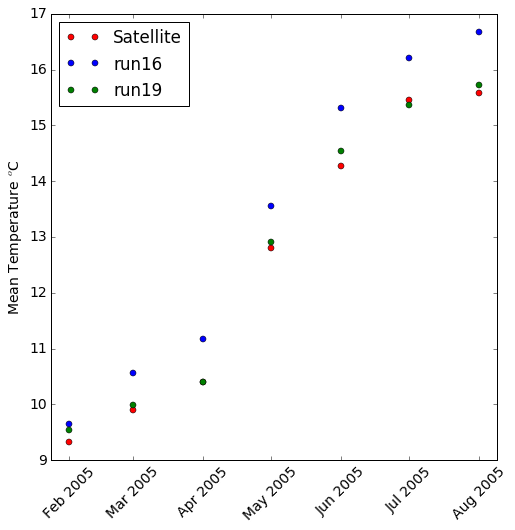

In [50]:
plt.figure(figsize = (8,8))
plt.plot(dates,sat,'or', label="Satellite")
plt.plot(dates,run16,'ob', label = "run16")
plt.plot(dates,run19,'og', label = "run19")
plt.legend(loc = 'upper left')
plt.ylabel('Mean Temperature $^o$C')
plt.xlim(731970,732167)
plt.xticks(rotation = 45)